# Using Bayesian Methods to Make Robust Inferences on E-learning Data

### Sanjay Renduchintala (vrenduch@andrew.cmu.edu)
---

**Motivation:** In "Knowledge-Learning-Instruction (KLI) Framework" [1], Koedinger et al. defined Knowledge Components (KCs) as an acquired cognitive function achieved by a learner by performing tasks. KCs can also be understood as a broad generalization of words such as concepts, rules, or skills a learner needs to solve a problem. Multiple learning theories have been proposed, generally modeled as Heirarchical Linear Models, to understand the granularity of KCs and refining KCs by analyzing the learning rate over the opportunities presented to practice KCs (OppKC).  

In this paper, I will be considering three variations of Additive Factor Model (AFM) to model student's probability of success. These models have practical implications in making pedagogical choices. For example, these models can be used in deciding the number of opportunities required to master a concept or making judgements about the quality of content available for practice. [2,3]

1) Strong Component Model (SCM):  Success ~ (1|Student) + KC + KC:OppKC <br>
2) Weak Component Model (WCM):    Success ~ (1|Student) + (1|Item) + KC:OppKC  <br>
3) Hierarchical Model (HM):      Success ~ (1|Student) + (1|KC/Item) + KC:OppKC  

The SCM models the student's probability of success on a task as sum of student's prior knowledge (random intercept), difficulty of the concept (KC intercept), and learning rate of the concept (KC slope). The WCM model assumes learning transfer at a more granular level and ignores the learning transfer at KC-level. It considers item random intercept instead of the KC intercept. The Hierarchical Model considers both KC and Item by using a random effect of Item nested under KC.

References:  
[1] K. R. Koedinger, A. T. Corbett, and C. Perfetti. The knowledge-learning- instruction framework: Bridging the science-practice chasm to enhance robust student learning. Cognitive science, 36(5):757–798, 2012.  <br>
[2] K. R. Koedinger, M. V. Yudelson, and P. I. Pavlik. Testing theories of transfer using error rate learning curves. Topics in cognitive science, 8(3):589–609, 2016.  <br>
[3] Koedinger, Kenneth & Sun, Lu & Mclaughlin, Elizabeth. Using a Hierarchical Model to Get the Best of Both Worlds: Good Prediction and Good Explanation. Conference: International Conference on Educational Data Mining, 2018.

**Data:** I used the [Geometry Area (1996-97)](https://pslcdatashop.web.cmu.edu/DatasetInfo?datasetId=76) dataset accessed via DataShop (Koedinger et al., 2010). This dataset has data from the area unit of the Geometry Cognitive Tutor course as it was used during the school year 1996-1997.  

**Columns of interest:**
* Anon_Student_Id - Anonymized student ID
* KC - Knowledge Concept
* OppKC - Number of KC opportunities
* Item - Question
* Success - Correct/Wrong attempt

**Correlation structure of the data**
* Items are nested within KCs
* Multiple observations for the same Item
* Multiple observations for the same Student

## 1. Data Preparation

In [1]:
import pystan as ps
import pandas as pd
import warnings
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

pd.set_option('display.max_columns', 500)
from anytree.resolver import Resolver
from anytree.importer import DictImporter
from anytree import RenderTree
from anytree.search import findall
import re
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [7]:
def data_prep(data, KC, OppKC):
    data.columns = [x.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_").replace(":", "_").replace(".", "_")
                        for x in data.columns]
    
    numeric_features = ['Step_Duration__sec_','Correct_Step_Duration__sec_', 'Corrects', 'Error_Step_Duration__sec_', 'Hints', 'Incorrects', 
                    'Problem_View', OppKC]
    categorical_features = ["Anon_Student_Id","Problem_Hierarchy","Problem_Name","Step_Name","First_Attempt",
                            KC,"Success"]
    datetime_features = ["Step_Start_Time","First_Transaction_Time","Correct_Transaction_Time","Step_End_Time"]    

    data.columns = [x.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_").replace(":", "_").replace(".", "_")
                    for x in data.columns]
    data["Success"] = 0
    data.Success[data.First_Attempt=="correct"] = 1
    
    data = data[categorical_features + numeric_features +  datetime_features]
    
    data.rename({KC: 'KC', OppKC: 'OppKC'}, axis=1, inplace=True)
    
    data = data[data.KC.notnull()]
    
    data['Item'] = data.Step_Name + data.Problem_Name
    data['OppItem'] = data.groupby(['Anon_Student_Id', 'Problem_Hierarchy', 'Item'])['OppKC'].rank()
    return data

In [3]:
ds76_raw = pd.read_csv("/Users/sanjayrenduchintala/Documents/LearnLab/variability/ds76_student_step_2020_0923_232343/ds76_student_step_All_Data_74_2020_0411_071130.txt", sep="\t", low_memory=False)

In [8]:
ds76 = data_prep(ds76_raw, "KC__LFASearchAICWholeModel3_", "Opportunity__LFASearchAICWholeModel3_")

In [11]:
# Keep only columns required for the analysis
ds76 = ds76[["Anon_Student_Id", "KC", "OppKC", "Item", "Success"]]

# Sample
ds76.head()

Anon_Student_Id  \
0  Stu_02ee1b3f31a6f6a7f4b8012298b2395e   
1  Stu_02ee1b3f31a6f6a7f4b8012298b2395e   
2  Stu_02ee1b3f31a6f6a7f4b8012298b2395e   
3  Stu_02ee1b3f31a6f6a7f4b8012298b2395e   
4  Stu_02ee1b3f31a6f6a7f4b8012298b2395e   

                                                  KC  OppKC  \
0                        Geometry*parallelogram-area      1   
1                        Geometry*parallelogram-area      2   
2                        Geometry*parallelogram-area      3   
3  Geometry*parallelogram-area*Textbook_New_Decom...      1   
4  Geometry*parallelogram-area*Textbook_New_Decom...      2   

                                                Item  Success  
0                     (AREA QUESTION1)RECTANGLE_ABCD        1  
1                   (HEIGHT QUESTION2)RECTANGLE_ABCD        1  
2                     (BASE QUESTION3)RECTANGLE_ABCD        1  
3           (POOL-AREA QUESTION1)BUILDING_A_SIDEWALK        1  
4  (LARGE-RECTANGLE-AREA QUESTION1)BUILDING_A_SID...        1

### Filtered dataset summary

In [12]:
print(
    '''Filtered Dataset Summary
---
Number of Students: {}
Number of Concepts: {}
Number of Questions: {}
Number of Observations: {}'''.format(len(set(list(ds76.Anon_Student_Id))),len(set(list(ds76.KC))),
                                         len(set(list(ds76.Item))),ds76.shape[0]))

Filtered Dataset Summary
---
Number of Students: 59
Number of Concepts: 18
Number of Questions: 139
Number of Observations: 5104


## 2. Data Exploration

### 2.1. Distribution of attempts for each concept by students

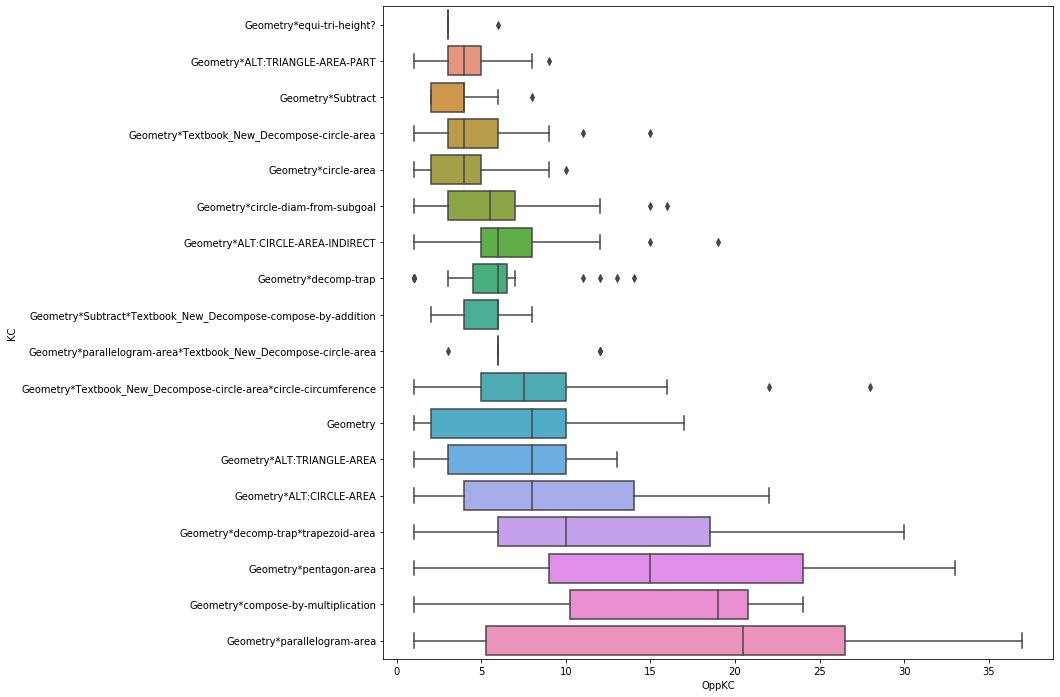

In [17]:
student_concept = ds76[["KC", "Anon_Student_Id", "OppKC"]].groupby(["KC", "Anon_Student_Id"], as_index=False).max()

a4_dims = (12, 12)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(y="KC", x="OppKC", data=student_concept, 
            order= student_concept.groupby(["KC"]).agg({'OppKC':'median'}).sort_values(by='OppKC', ascending=True).index)
plt.show()

**Observation:** Students are practicing some concepts more than other, and there is also a variation across students in how much they are practicing a given KC. 

### 2.2. Student participation

#### 2.2.1. Number of students who attempted a concept

In [19]:
ds76[["Anon_Student_Id","KC"]].drop_duplicates().groupby("KC").count().sort_values(by='Anon_Student_Id')

Anon_Student_Id
KC                                                                 
Geometry*equi-tri-height?                                        28
Geometry*Subtract                                                29
Geometry*decomp-trap                                             31
Geometry*ALT:TRIANGLE-AREA-PART                                  33
Geometry*circle-area                                             33
Geometry*parallelogram-area*Textbook_New_Decomp...               33
Geometry*Textbook_New_Decompose-circle-area*cir...               34
Geometry*compose-by-multiplication                               34
Geometry*circle-diam-from-subgoal                                34
Geometry*pentagon-area                                           35
Geometry*ALT:TRIANGLE-AREA                                       35
Geometry*ALT:CIRCLE-AREA-INDIRECT                                36
Geometry*decomp-trap*trapezoid-area                              38
Geometry*ALT:CIRCLE-AREA                                         38
Geometry*Subtract*Textbook_New_Decompose-compos...               39
Geometry*Textbook_New_Decompose-circle-area                      41
Geometry                                                         41
Geometry*parallelogram-area                                      46

#### 2.2.2. Number of concepts attempted by students

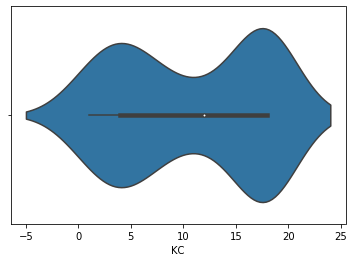

In [30]:
student_success = ds76[["Anon_Student_Id", "KC", "Success"]].groupby(["Anon_Student_Id", "KC"], as_index=False).mean()
sns.violinplot(student_success[["Anon_Student_Id","KC"]].drop_duplicates().groupby("Anon_Student_Id").count()['KC'])

**Observation:** Not every student practices all the concepts.

## 3. Data Preparation for Stan Models

In [31]:
# Numeric index for student ID
ds76["student"] = pd.Categorical(ds76.Anon_Student_Id).codes
ds76.student += 1

In [32]:
# Numeric index for KC
ds76["kc"] = pd.Categorical(ds76.KC).codes
ds76.kc += 1

In [34]:
# Numeric index for Item
ds76["item"] = pd.Categorical(ds76.Item).codes
ds76.item += 1

In [35]:
# Item-KC mapping
item_kc = ds76[['kc','KC','item']].drop_duplicates().sort_values(by='item')['kc'].values

In [36]:
# Prediction Dataset
ds76_pred = ds76[['kc',"KC",'OppKC']].drop_duplicates()

In [69]:
# KC to index mapping
ds76[['kc','KC']].drop_duplicates().sort_values(by='kc')

kc                                                 KC
20    1                                           Geometry
128   2                           Geometry*ALT:CIRCLE-AREA
125   3                  Geometry*ALT:CIRCLE-AREA-INDIRECT
56    4                         Geometry*ALT:TRIANGLE-AREA
59    5                    Geometry*ALT:TRIANGLE-AREA-PART
228   6                                  Geometry*Subtract
8     7  Geometry*Subtract*Textbook_New_Decompose-compo...
5     8        Geometry*Textbook_New_Decompose-circle-area
126   9  Geometry*Textbook_New_Decompose-circle-area*ci...
130  10                               Geometry*circle-area
131  11                  Geometry*circle-diam-from-subgoal
60   12                 Geometry*compose-by-multiplication
227  13                               Geometry*decomp-trap
28   14                Geometry*decomp-trap*trapezoid-area
213  15                          Geometry*equi-tri-height?
0    16                        Geometry*parallelogram-area
3    17  Geometry*parallelogram-area*Textbook_New_Decom...
74   18                             Geometry*pentagon-area

## 4. Strong Component Model

### 4.1. Model definition

In [37]:
scm = """
data {
  int<lower=1> N; // number of observations
  int<lower=0,upper=1> y[N]; // correctness
  vector[N] OppKC; // Opportunity to practice
  int<lower=1> S; // # of students
  int<lower=1, upper=S> student[N]; //student
  int<lower=1> K; // # of KCs
  int<lower=1, upper=K> kc[N]; // KCs
  
  int<lower=1> N_pred;
  int<lower=1, upper=K> kc_pred[N_pred]; // KCs
  vector[N_pred] OppKC_pred; // Opportunity to practice
  
}
parameters {
  vector[K] alpha; // intercept for each KC
  vector[K] beta; // slope for each KC
  vector[S] stu_eff; // student random effect
  real<lower=0> sigma_s; // sd of student random effect 
}
model {

  sigma_s ~ inv_gamma(0.5, 0.5); // jeffrey's prior
  stu_eff ~ normal(0, sigma_s);

  beta ~ normal(0, 1); // generic weakly informative prior
  
  for (i in 1:N){
    y[i] ~ bernoulli_logit(alpha[kc[i]] + stu_eff[student[i]] + OppKC[i] * beta[kc[i]]);
  }
}

generated quantities {
//sample predicted values from the model for posterior predictive checks
  real y_pred[N_pred];
  for(i in 1:N_pred)
    y_pred[i] = bernoulli_logit_rng(alpha[kc_pred[i]] + normal_rng(0,sigma_s) + OppKC_pred[i] * beta[kc_pred[i]]);
}

"""

In [38]:
scm_model = ps.StanModel(model_code=scm)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2606b05367145282edefbd244a759f0 NOW.


In [39]:
%%time
data_dict = {"N": len(ds76), "OppKC": ds76.OppKC.values,
             "S": ds76.student.max(), "K": ds76.kc.max(), "student": ds76.student.values, "kc": ds76.kc.values,
             "y": ds76.Success.values, "N_pred": len(ds76_pred), "kc_pred": ds76_pred.kc.values, 
             "OppKC_pred": ds76_pred.OppKC.values}
scm_fit = scm_model.sampling(data=data_dict, chains=4, iter= 15500, warmup= 500)

CPU times: user 7.61 s, sys: 492 ms, total: 8.1 s
Wall time: 7min 38s


### 4.2. Diagnostics

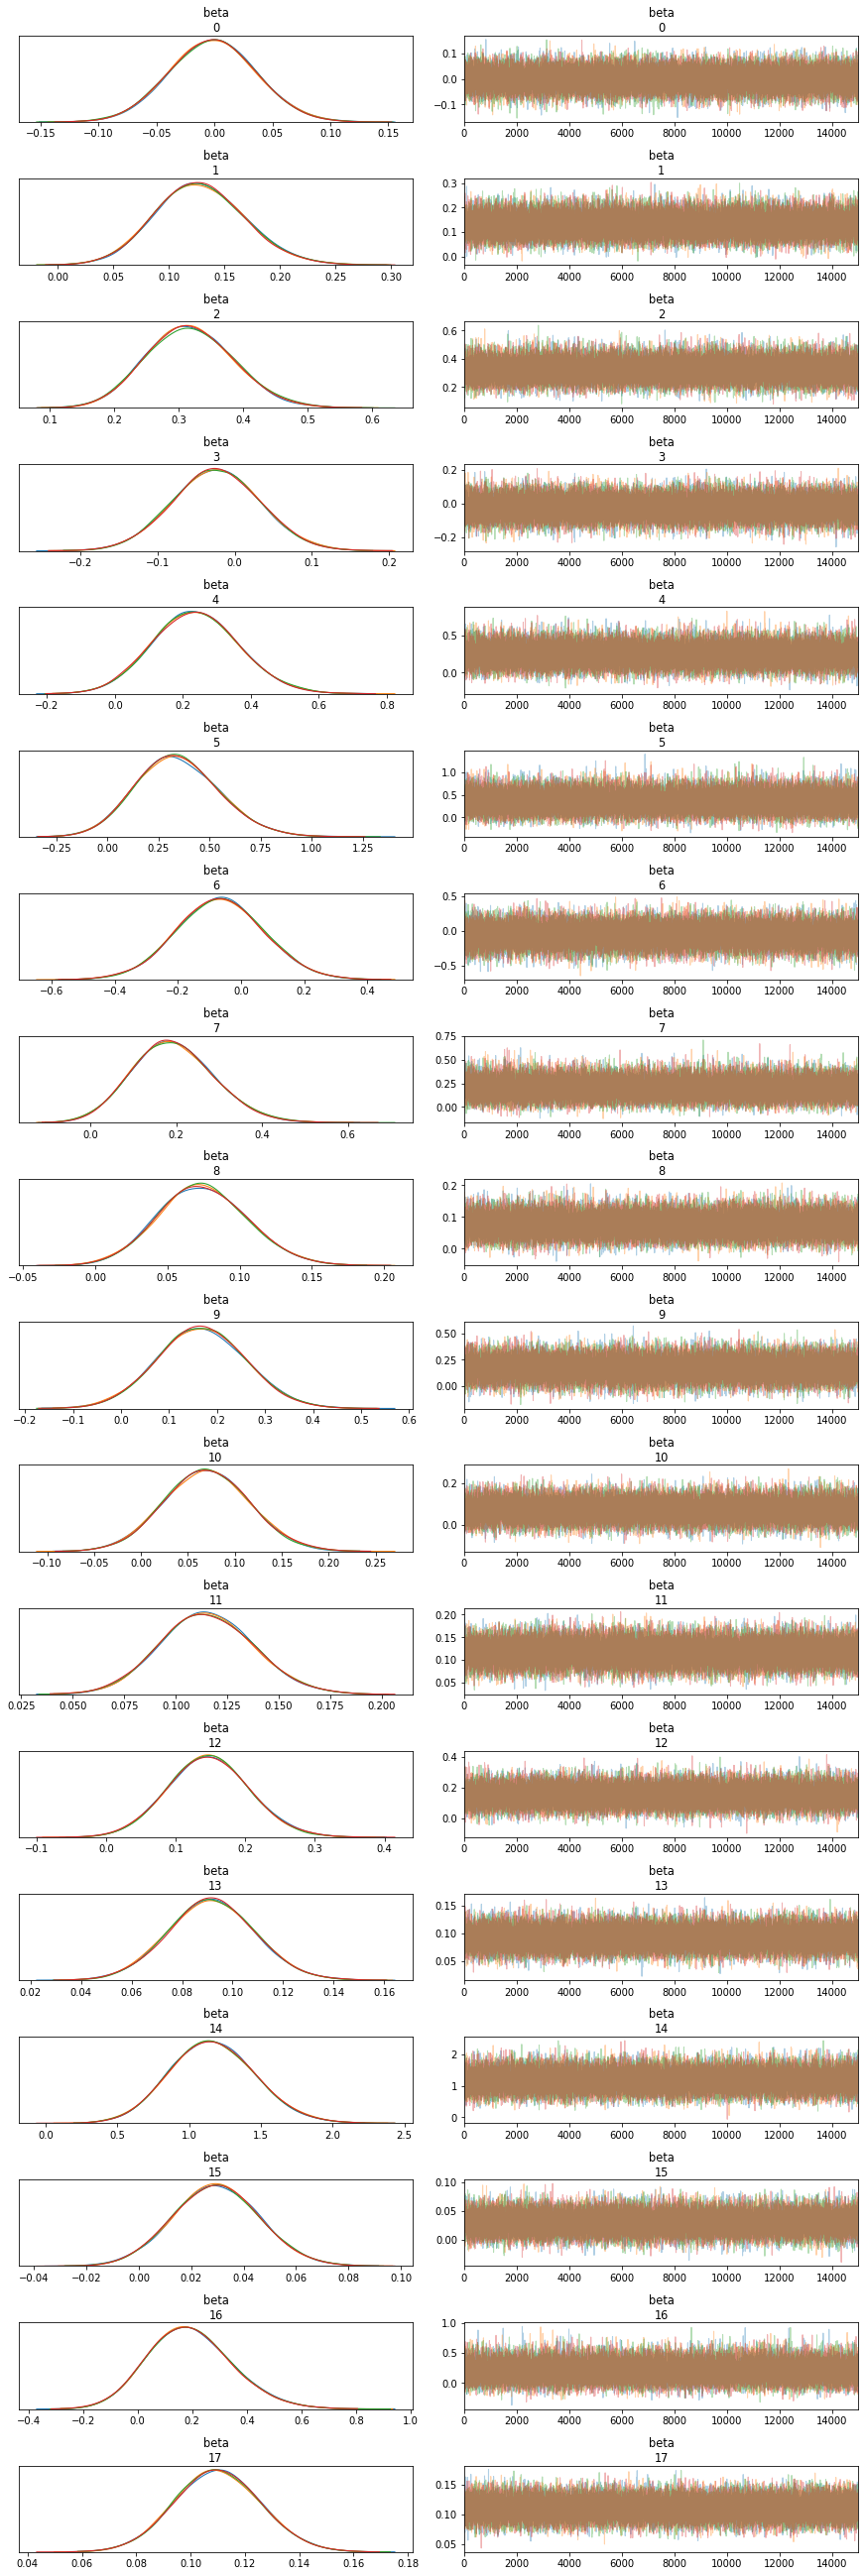

In [48]:
az.plot_trace(scm_fit,var_names=('beta'))
plt.show()

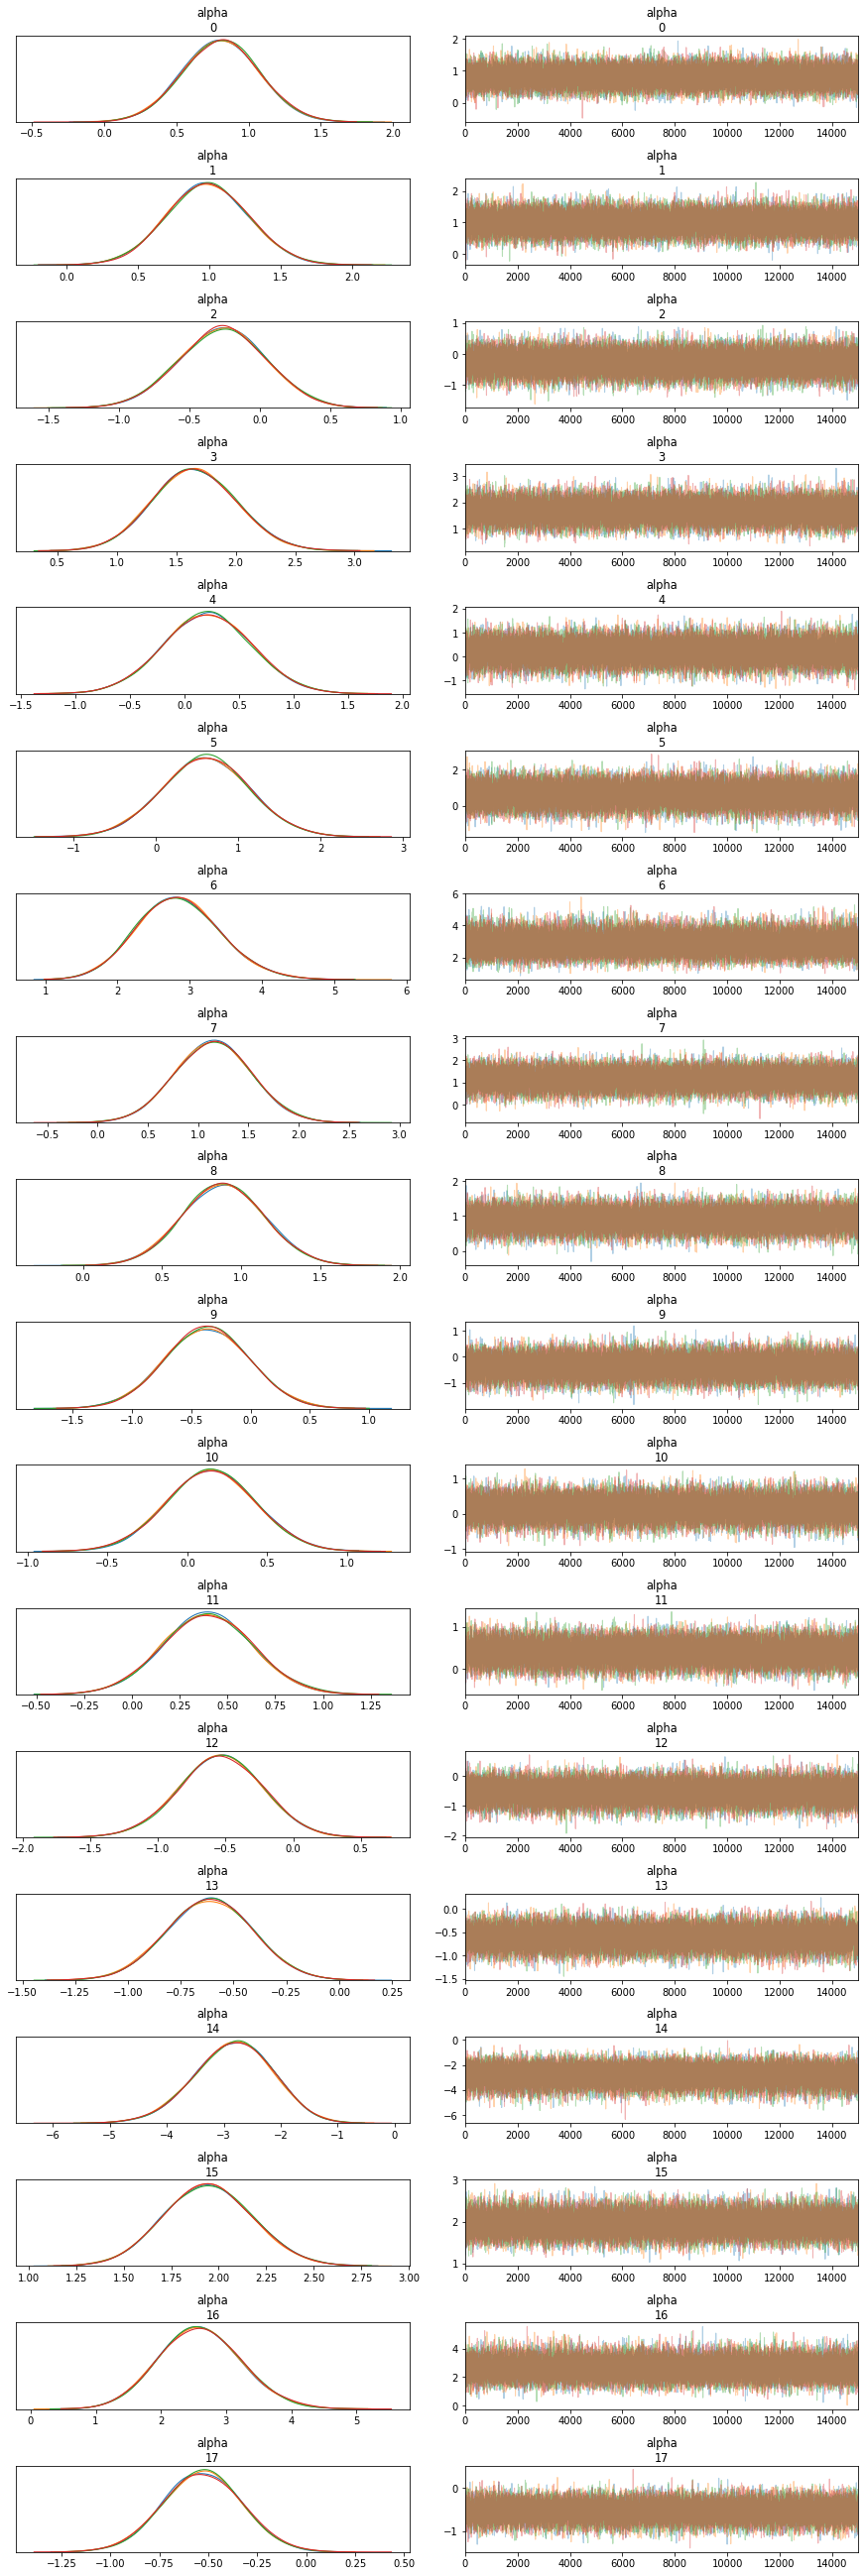

In [81]:
az.plot_trace(scm_fit,var_names=('alpha'))
plt.show()

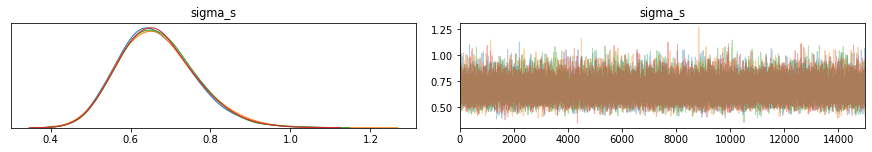

In [80]:
az.plot_trace(scm_fit,var_names=('sigma_s'))
plt.show()

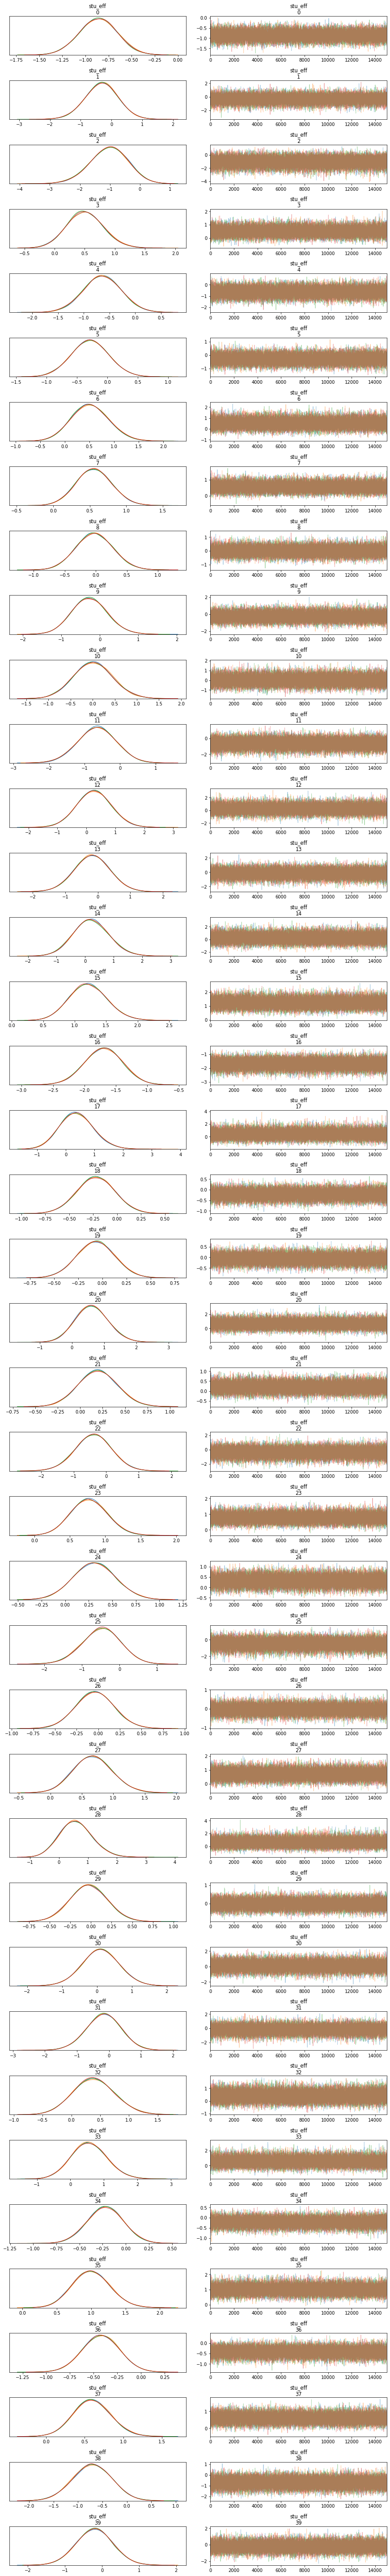

In [82]:
az.plot_trace(scm_fit,var_names=('stu_eff'))
plt.show()

**Observation:** All the traceplots look good!

### 4.3. Parameter Inference

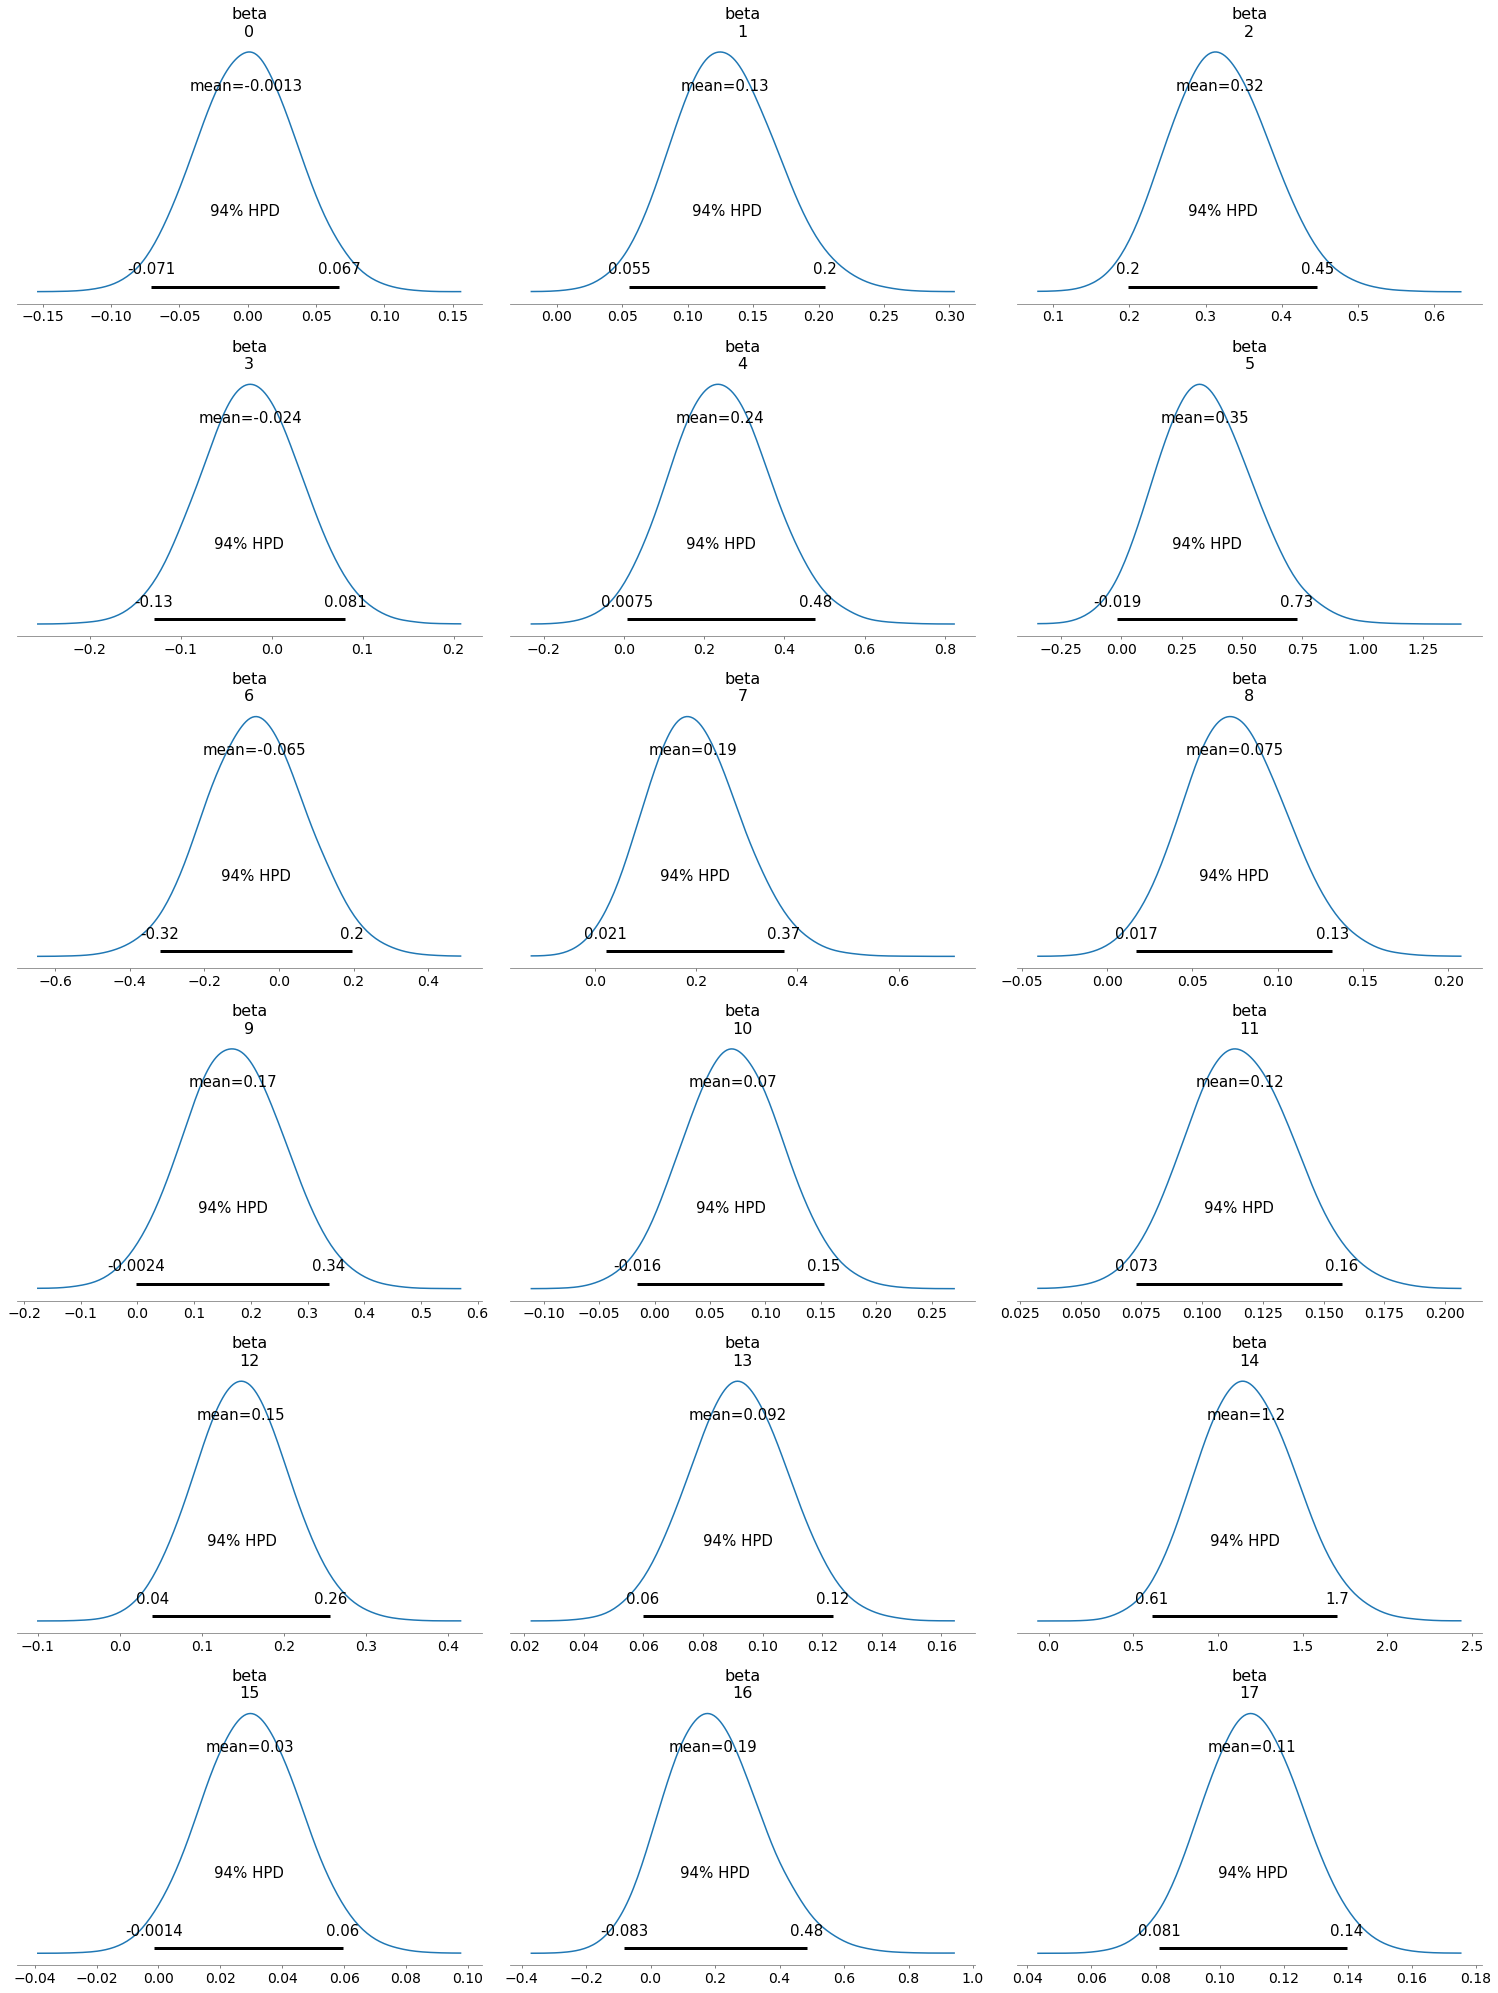

In [50]:
az.plot_posterior(scm_fit,var_names='beta')
plt.show()

**Observation:** Confidence region of betas indicates the true range of increase/decrease of log-odds of success with OppKC. This gives us an idea about the spread of learning rates in the classroom. This is more useful than having a confidence interval for "true beta".

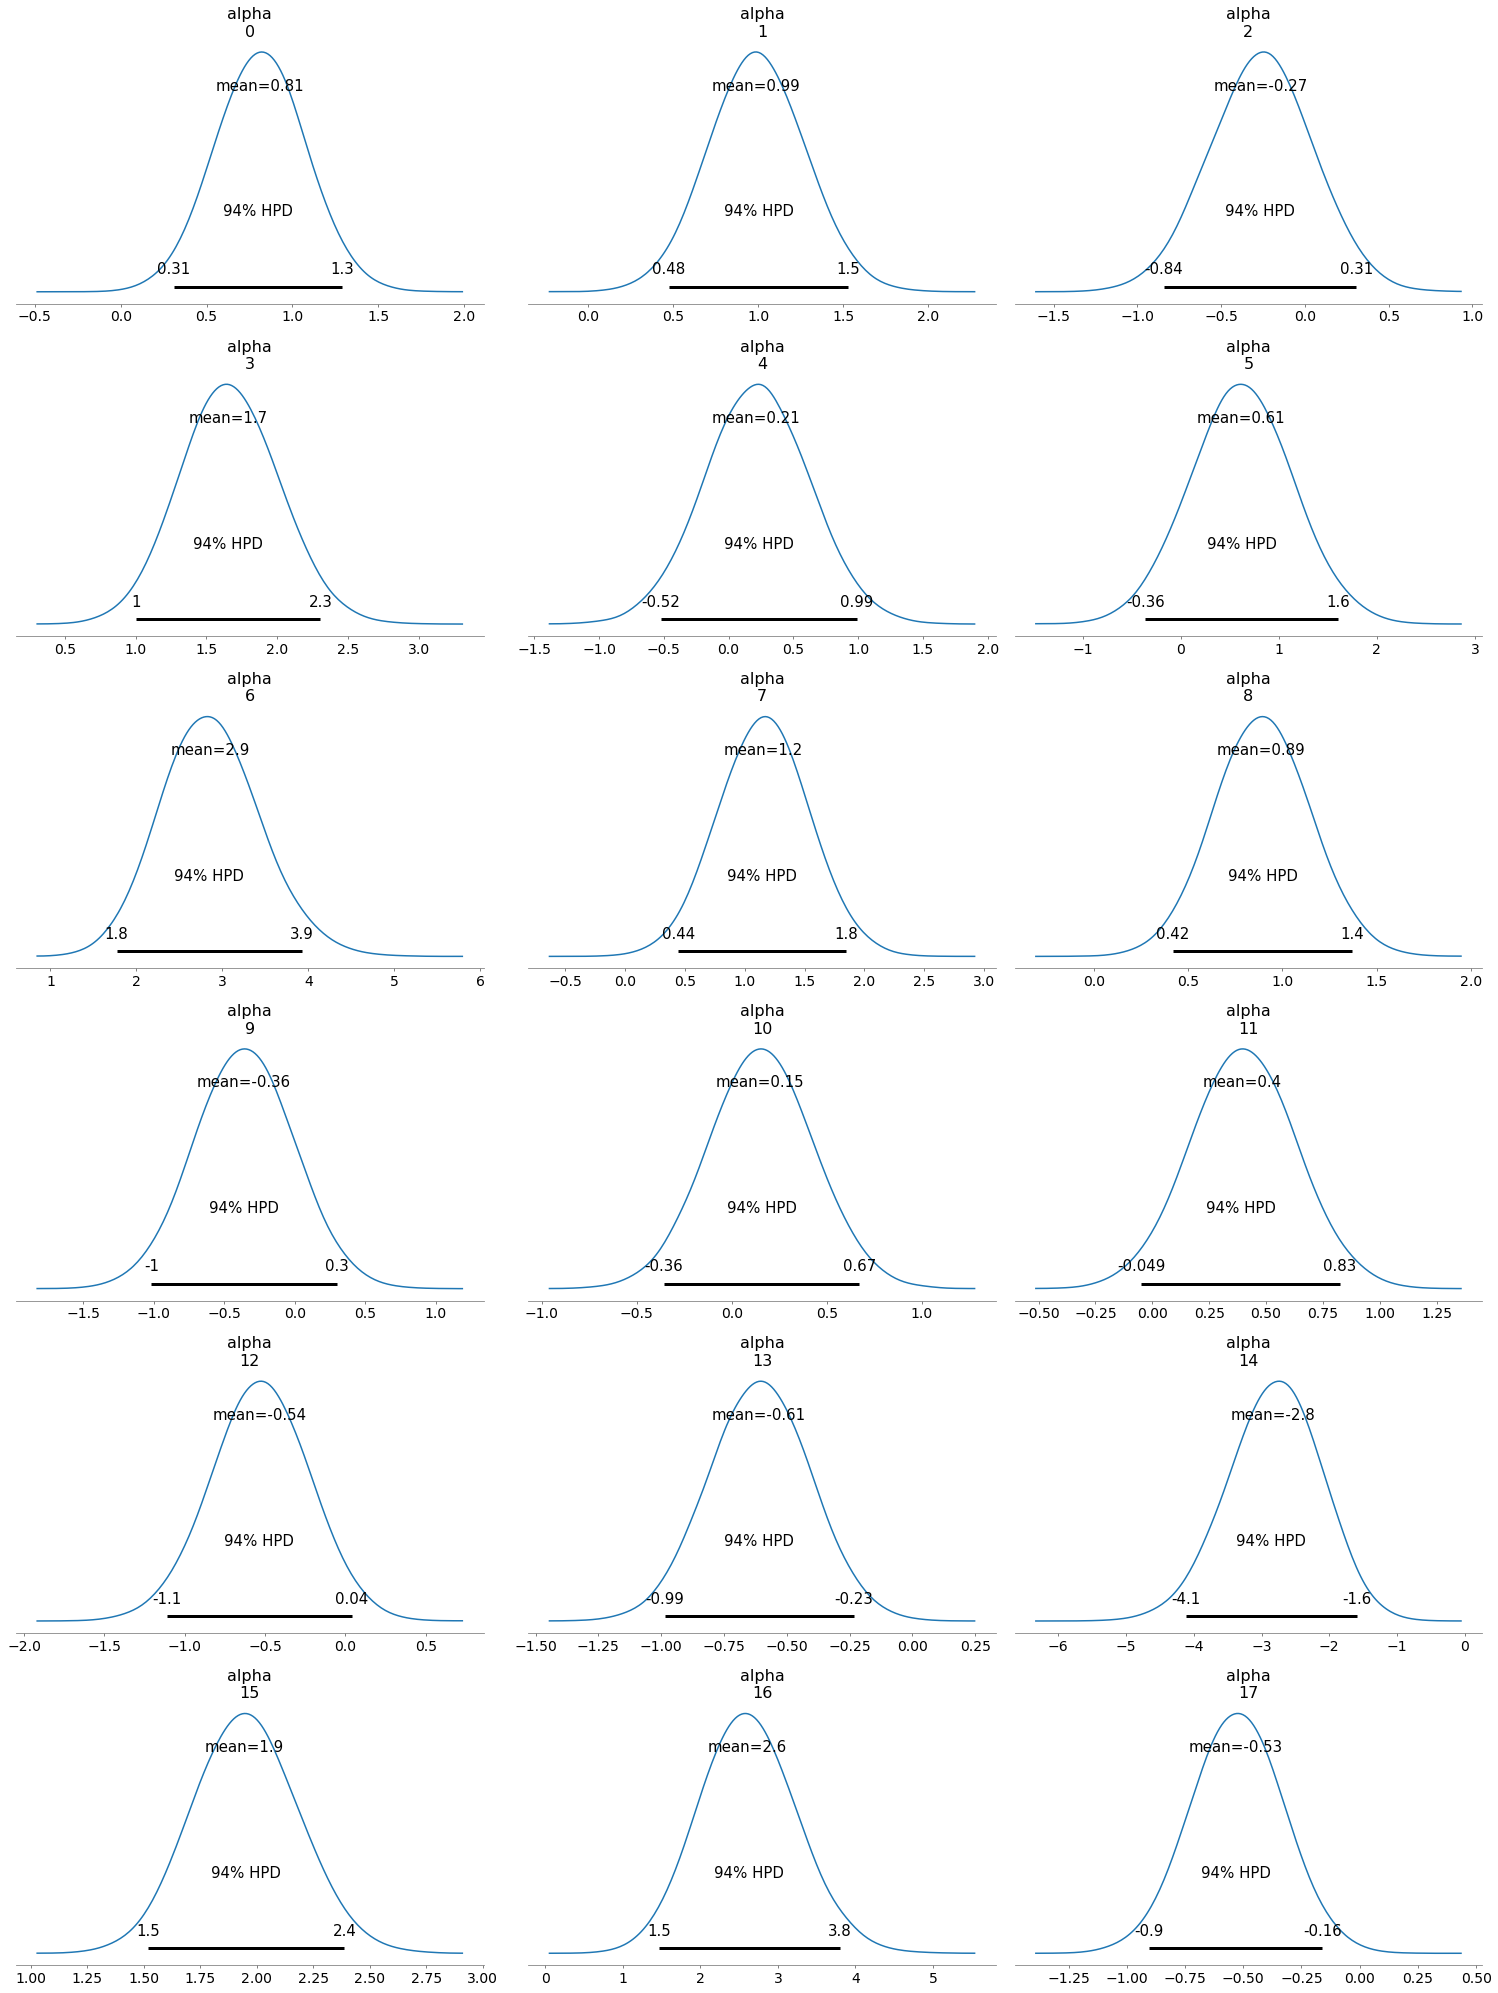

In [51]:
az.plot_posterior(scm_fit,var_names='alpha')
plt.show()

**Observation:** Confidence region of alphas indicates the true range of the levels difficulty available for each KC. This is more useful than having a confidence interval for "true alpha".

### 4.4. Understanding learning for each KC

In [52]:
predicted_scm = np.mean(scm_fit.extract('y_pred')['y_pred'],axis=0)

In [53]:
ds76_pred['p_success_scm'] = predicted_scm

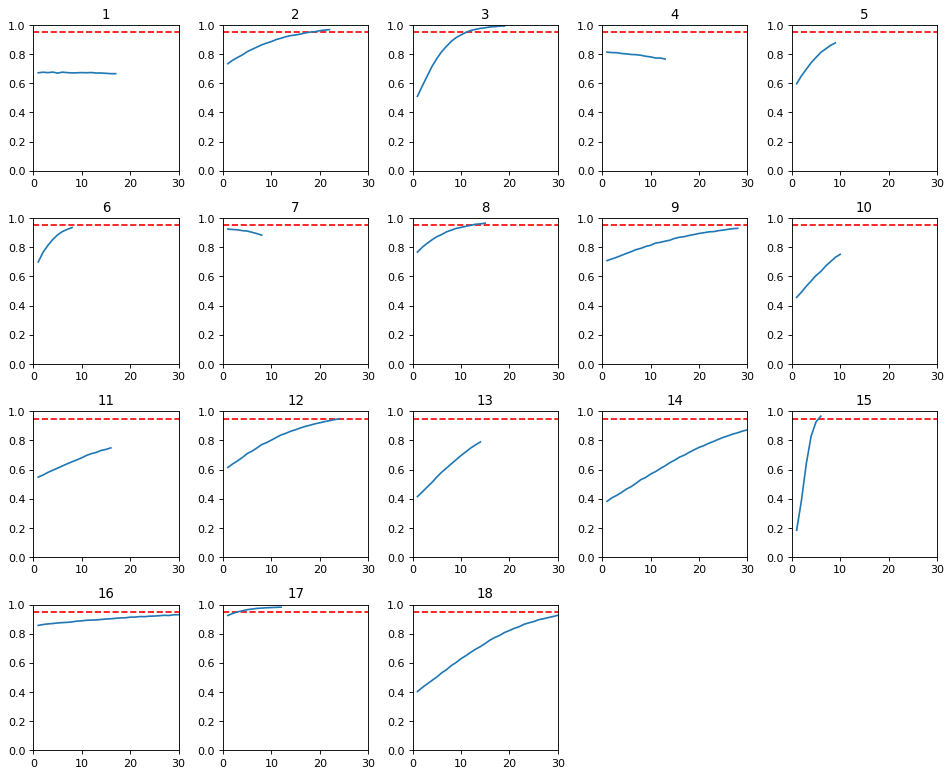

In [79]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for c in range(1,ds76_pred.kc.max()+1):
    df0=ds76_pred[ds76_pred['kc']==c]
    ax = fig.add_subplot(5,5,c)
    ax.axhline(0.95, color='red', linestyle='--')
    ax.set_xlim([0,30])
    ax.set_ylim([0,1])
    ax.plot(df0['OppKC'], df0['p_success_scm'])
    ax.set_title(c)

plt.tight_layout()
plt.show()

**Observation:** The above plots are generated to generalize the learning model to unseen students. By averaging over the random effects, we are able to predict the probability of success with additional opportunities. We expect students to practice a concept till they achieve master (p(Success)=.95m,as indicated by the red line). The above graphs show us: 1) concepts where students aren't practicing enough (not enough content? need more time?), 2) students practicing after they've mastered a concept (wasted effort), and 3) concepts with no learning (need better content or instruction?). This analysis can be used to improve the course content. 

**Note:** This simulation is not an obvious result when we use a frequentist method. Most people approximate p(Success) as E(logisitic(fixed effects)) while generalizing to unseen students. Even though random effects are normally distributed with mean 0, we cannot ignore the random effects while calculating the expected value of p(Success). This is because E(logistic(fixed effects)) ≠ E(logistic(fixed effects + normal(0, sigma)). Bayesian method allows us to calculate E(p(Success)) while averaging over the random effects. 

## 5. Weak Component Model

### 5.1. Model definition

In [40]:
wcm = """
data {
  int<lower=1> N; // number of observations
  int<lower=0,upper=1> y[N]; // correctness
  vector[N] OppKC; // Opportunity to practice
  int<lower=1> S; // # of students
  int<lower=1, upper=S> student[N]; //student
  int<lower=1> I; // # of items
  int<lower=1, upper=I> item[N]; // items
  int<lower=1> K; // # of KCs
  int<lower=1, upper=K> kc[N]; // KCs
  
  int<lower=1> N_pred;
  int<lower=1, upper=K> kc_pred[N_pred]; // KCs
  vector[N_pred] OppKC_pred; // Opportunity to practice
}
parameters {
  real alpha; // intercept
  vector[K] beta; // slope for each KC
  vector[S] stu_eff; // student random effect
  vector[I] item_eff; //item random effect
  real<lower=0> sigma_s; // sd of student random effect 
  real<lower=0> sigma_i; // sd of item random effect
}
model {

  //weakly informative priors from STAN user guide (instead of jeffrey's prior)
  sigma_s ~ cauchy(0,2.5);
  sigma_i ~ cauchy(0,2.5);

  stu_eff ~ normal(0, sigma_s);
  item_eff ~ normal(0, sigma_i);
  
  beta ~ normal(0, 1); // generic weakly informative prior
  
  for (i in 1:N){
    y[i] ~ bernoulli_logit(alpha + stu_eff[student[i]] + item_eff[item[i]] + OppKC[i] * beta[kc[i]]);
  }
}

generated quantities {
//sample predicted values from the model for posterior predictive checks
  real y_pred[N_pred];
  for(i in 1:N_pred)
    y_pred[i] = bernoulli_logit_rng(alpha + normal_rng(0,sigma_s) + normal_rng(0,sigma_i) + OppKC_pred[i] * beta[kc_pred[i]]);
}
"""

In [41]:
wcm_model = ps.StanModel(model_code=wcm)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_745d070046f85279ec67d2ffca65acc2 NOW.


In [43]:
%%time
data_dict = {"N": len(ds76), "OppKC": ds76.OppKC.values,
             "S": ds76.student.max(), "I": ds76.item.max(), "student": ds76.student.values, "item": ds76.item.values,
             "K": ds76.kc.max(), "kc": ds76.kc.values,
             "y": ds76.Success.values, "N_pred": len(ds76_pred), "kc_pred": ds76_pred.kc.values, 
             "OppKC_pred": ds76_pred.OppKC.values}
wcm_fit = wcm_model.sampling(data=data_dict, chains=4, iter= 15500, warmup= 500)

CPU times: user 9.79 s, sys: 591 ms, total: 10.4 s
Wall time: 5min 58s


### 5.2. Diagnostics

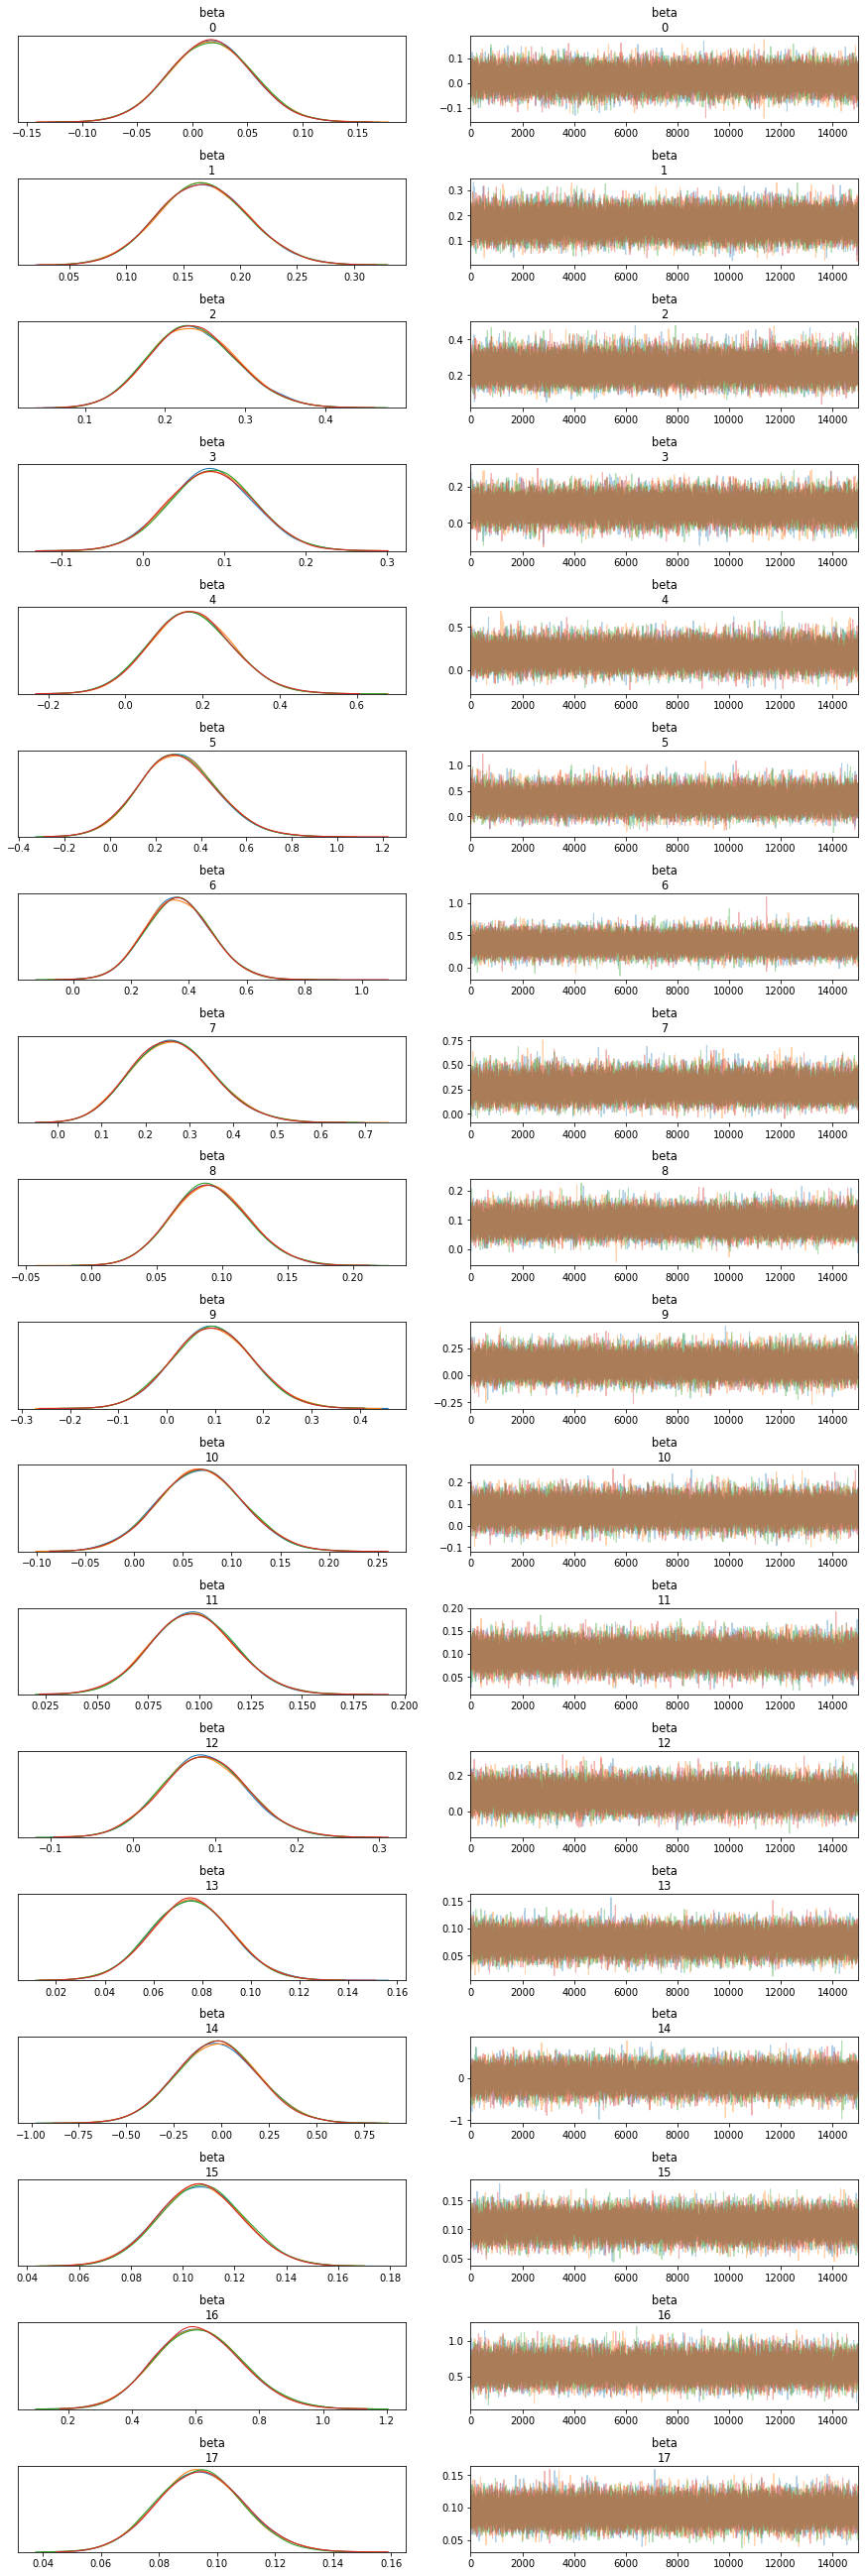

In [55]:
az.plot_trace(wcm_fit,var_names=('beta'))
plt.show()

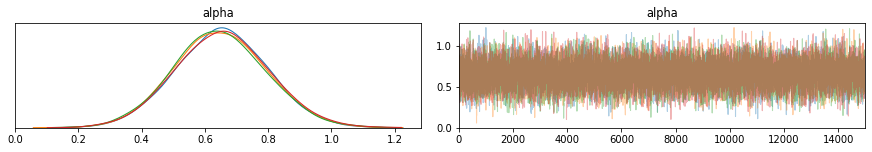

In [56]:
az.plot_trace(wcm_fit,var_names=('alpha'))
plt.show()

**Observation:** All the traceplots look good!

**Note:** Trace plots were shown only for alpha and beta to save space.

### 5.3. Parameter Inference

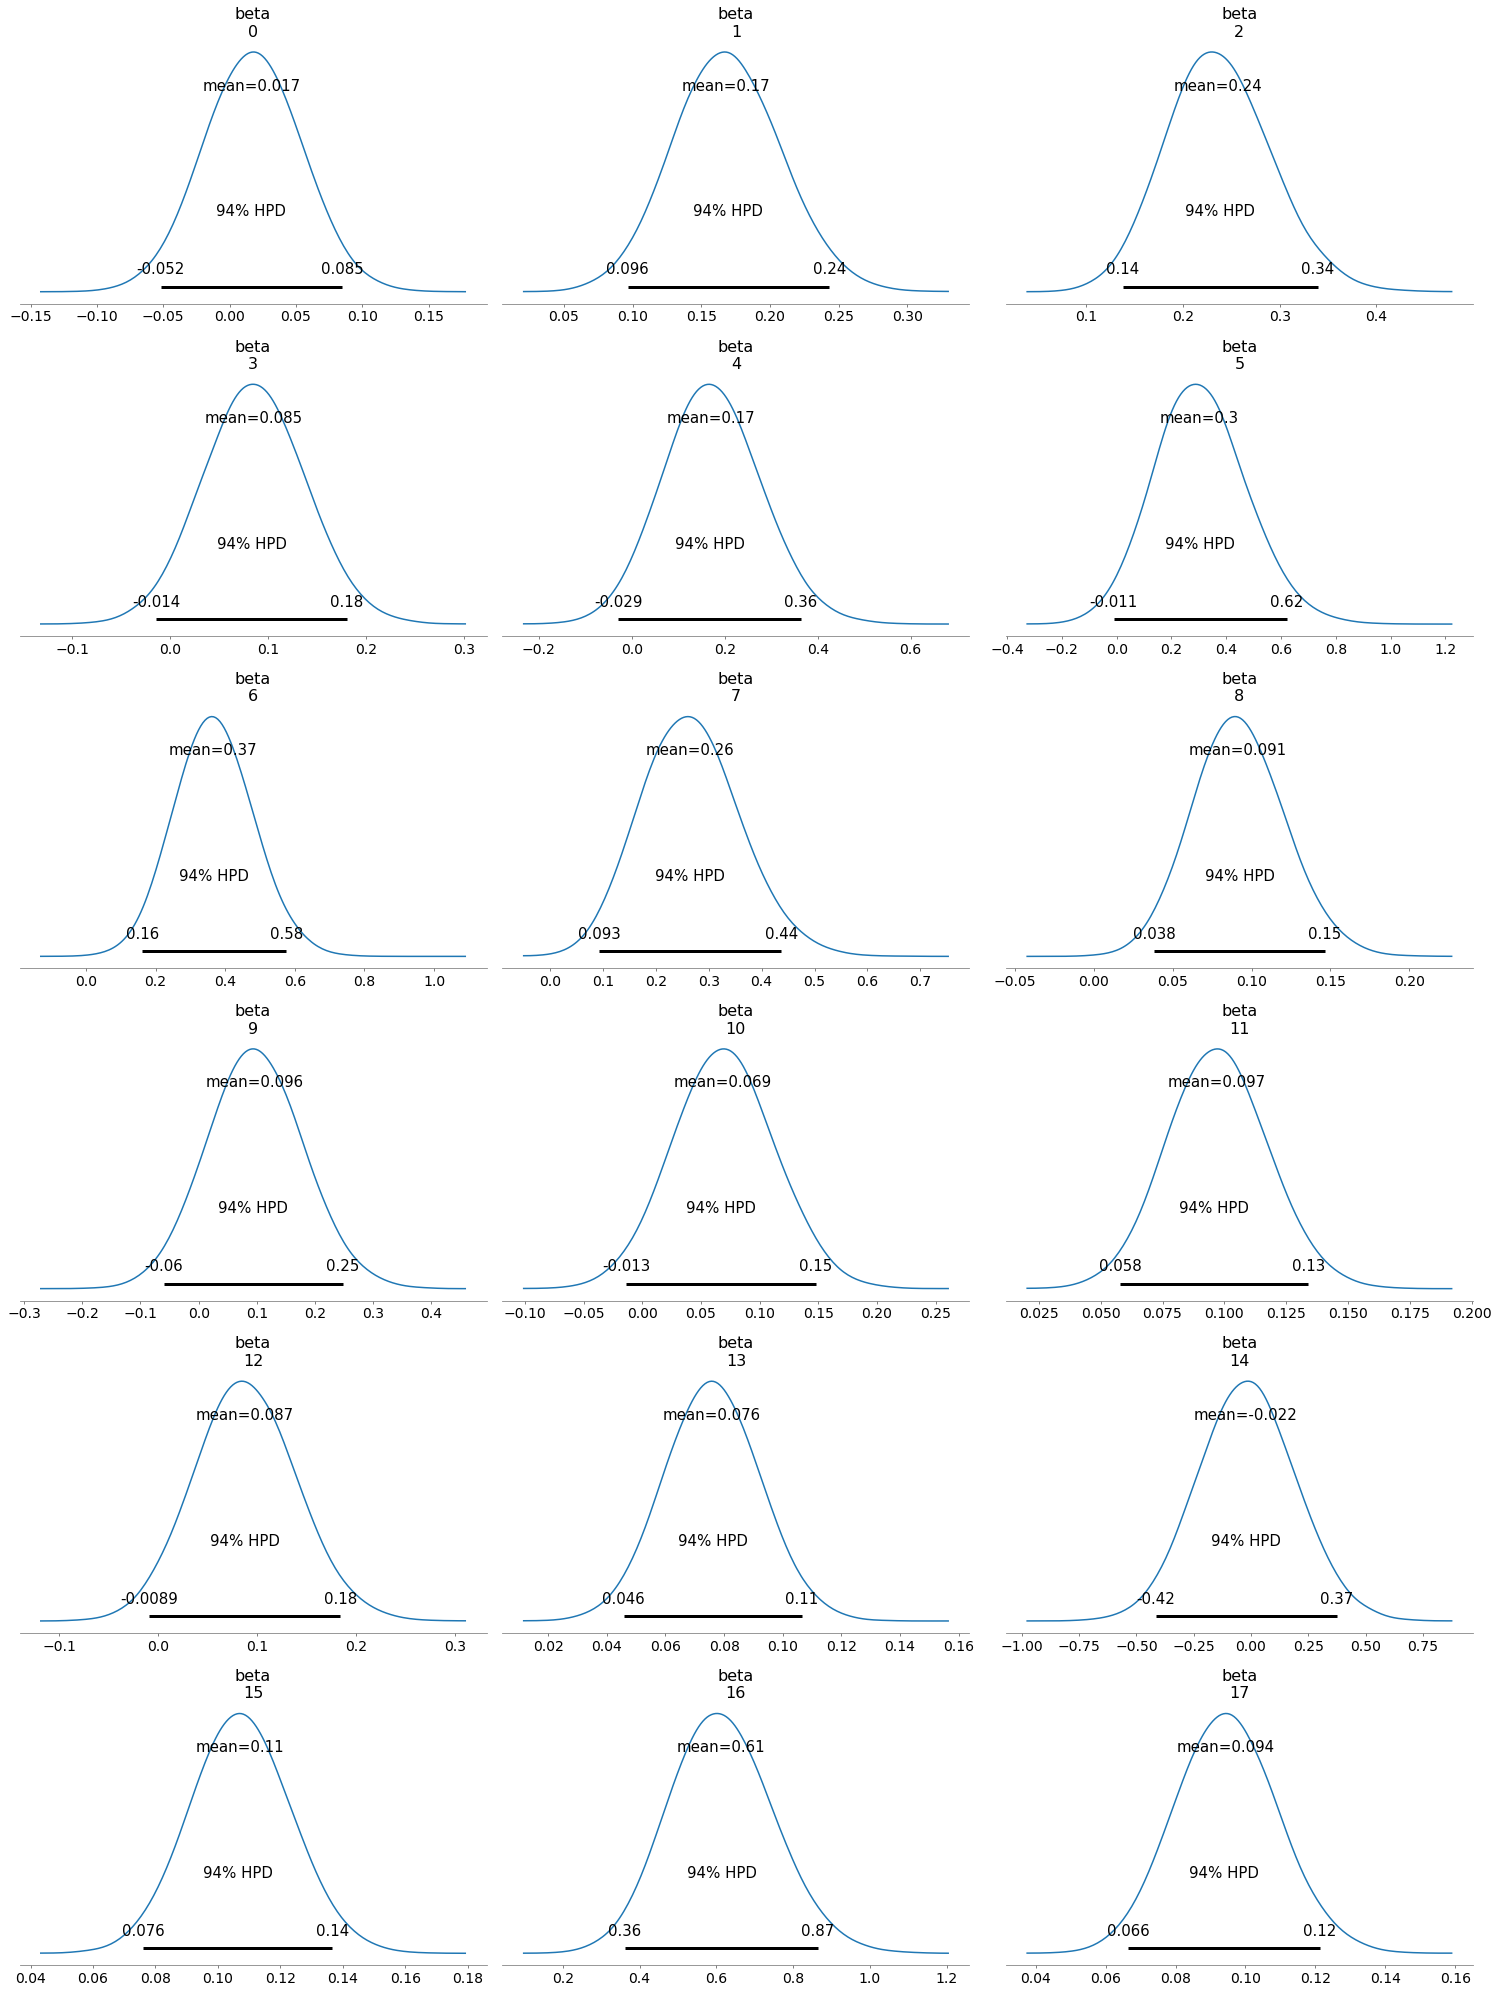

In [57]:
az.plot_posterior(wcm_fit,var_names='beta')
plt.show()

**Observation:** Confidence region of betas indicates the true range of increase/decrease of log-odds of success with OppKC. This gives us an idea about the spread of learning rates in the classroom. This is more useful than having a confidence interval for "true beta".

### 5.4. Understanding learning for each KC

In [59]:
predicted_wcm = np.mean(wcm_fit.extract('y_pred')['y_pred'],axis=0)

In [60]:
ds76_pred['p_success_wcm'] = predicted_wcm

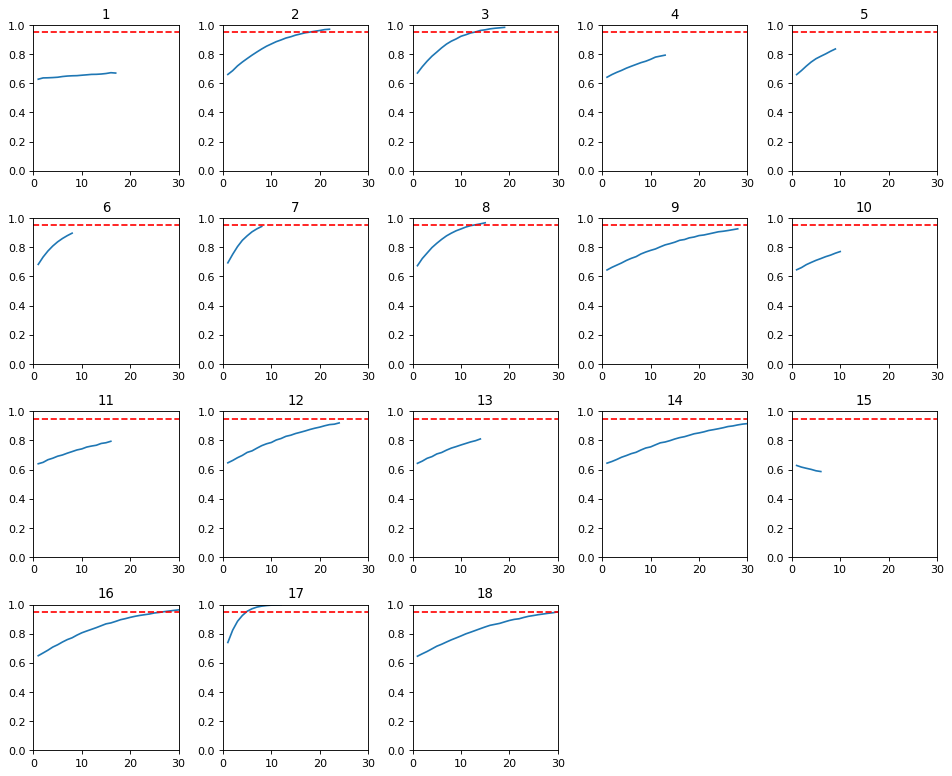

In [77]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for c in range(1,ds76_pred.kc.max()+1):
    df0=ds76_pred[ds76_pred['kc']==c]
    ax = fig.add_subplot(5,5,c)
    ax.plot(df0['OppKC'], df0['p_success_wcm'])
    ax.axhline(0.95, color='red', linestyle='--')
    ax.set_xlim([0,30])
    ax.set_ylim([0,1])
    ax.set_title(c)

plt.tight_layout()
plt.show()

**Observation:** The above plots are generated to generalize the learning model to unseen students. By averaging over the random effects, we are able to predict the probability of success with additional opportunities. We expect students to practice a concept till they achieve master (p(Success)=.95m,as indicated by the red line). The above graphs show us: 1) concepts where students aren't practicing enough (not enough content? need more time?), 2) students practicing after they've mastered a concept (wasted effort), and 3) concepts with no learning (need better content or instruction?). This analysis can be used to improve the course content. 

**Note:** This simulation is not an obvious result when we use a frequentist method. Most people approximate p(Success) as E(logisitic(fixed effects)) while generalizing to unseen students. Even though random effects are normally distributed with mean 0, we cannot ignore the random effects while calculating the expected value of p(Success). This is because E(logistic(fixed effects)) ≠ E(logistic(fixed effects + normal(0, sigma)). Bayesian method allows us to calculate E(p(Success)) while averaging over the random effects. 

## 6. Hierarchical Model

### 6.1. Model definition

In [44]:
hcm = """
data {
  int<lower=1> N; // number of observations
  int<lower=0,upper=1> y[N]; // correctness
  vector[N] OppKC; // Opportunity to practice
  int<lower=1> S; // # of students
  int<lower=1, upper=S> student[N]; //student
  int<lower=1> I; // # of items
  int<lower=1, upper=I> item[N]; // items
  int<lower=1> K; // # of KCs
  int<lower=1, upper=K> kc[N]; // KCs
  int<lower=1, upper=K> item_kc[I]; // item to kc mapping
    
  int<lower=1> N_pred;
  int<lower=1, upper=K> kc_pred[N_pred]; // KCs
  vector[N_pred] OppKC_pred; // Opportunity to practice
}
parameters {
  real alpha; // intercept
  vector[K] beta; // slope for each KC
  vector[S] stu_eff; // student random effect
  vector[I] item_eff; //item random effect
  vector[K] kc_eff; // KC random effect
  real<lower=0> sigma_s; // sd of student random effect 
  real<lower=0> sigma_i; // sd of item random effect
  real<lower=0> sigma_k; // sd of kc random effect
}
transformed parameters {

  real intercept_kc[K];
  real intercept_kc_item[I];
  real theta[N];

  for (k in 1:K){
    intercept_kc[k] = alpha + kc_eff[k];
  }
  
  for (i in 1:I){
    intercept_kc_item[i] = intercept_kc[item_kc[i]] + item_eff[i];
  }
  
  for (n in 1:N){
    theta[n] = stu_eff[student[n]] + intercept_kc_item[item[n]] + (OppKC[n] * beta[kc[n]]);
  }
  
}

model {

  //weakly informative priors based on STAN user guide
  sigma_s ~ cauchy(0,2.5);
  sigma_i ~ cauchy(0,2.5);
  sigma_k ~ cauchy(0,2.5);
  
  beta ~ normal(0, 1); // generic weakly informative prior

  stu_eff ~ normal(0, sigma_s);
  item_eff ~ normal(0, sigma_i);
  kc_eff ~ normal(0, sigma_k);
  
  y ~ bernoulli_logit(theta);

}

generated quantities {
//sample predicted values from the model for posterior predictive checks
  real y_pred[N_pred];
  for(n in 1:N_pred)
    y_pred[n] = bernoulli_logit_rng(alpha + normal_rng(0,sigma_s) + normal_rng(0,sigma_i) + normal_rng(0,sigma_k) + 
    OppKC_pred[n] * beta[kc_pred[n]]);
}
"""

In [45]:
hcm_model = ps.StanModel(model_code=hcm)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0b34161d19dd1951ffa2d1771a28ba8 NOW.


In [47]:
%%time
data_dict = {"N": len(ds76), "OppKC": ds76.OppKC.values,
             "S": ds76.student.max(), "I": ds76.item.max(), "student": ds76.student.values, "item": ds76.item.values,
             "K": ds76.kc.max(), "kc": ds76.kc.values, "item_kc": item_kc,"y": ds76.Success.values,
             "N_pred": len(ds76_pred), "kc_pred": ds76_pred.kc.values, "OppKC_pred": ds76_pred.OppKC.values}
hcm_fit = hcm_model.sampling(data=data_dict, chains=4, iter= 15500, warmup= 500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 3.84 s, sys: 6.83 s, total: 10.7 s
Wall time: 10min 52s


### 6.2. Diagnostics

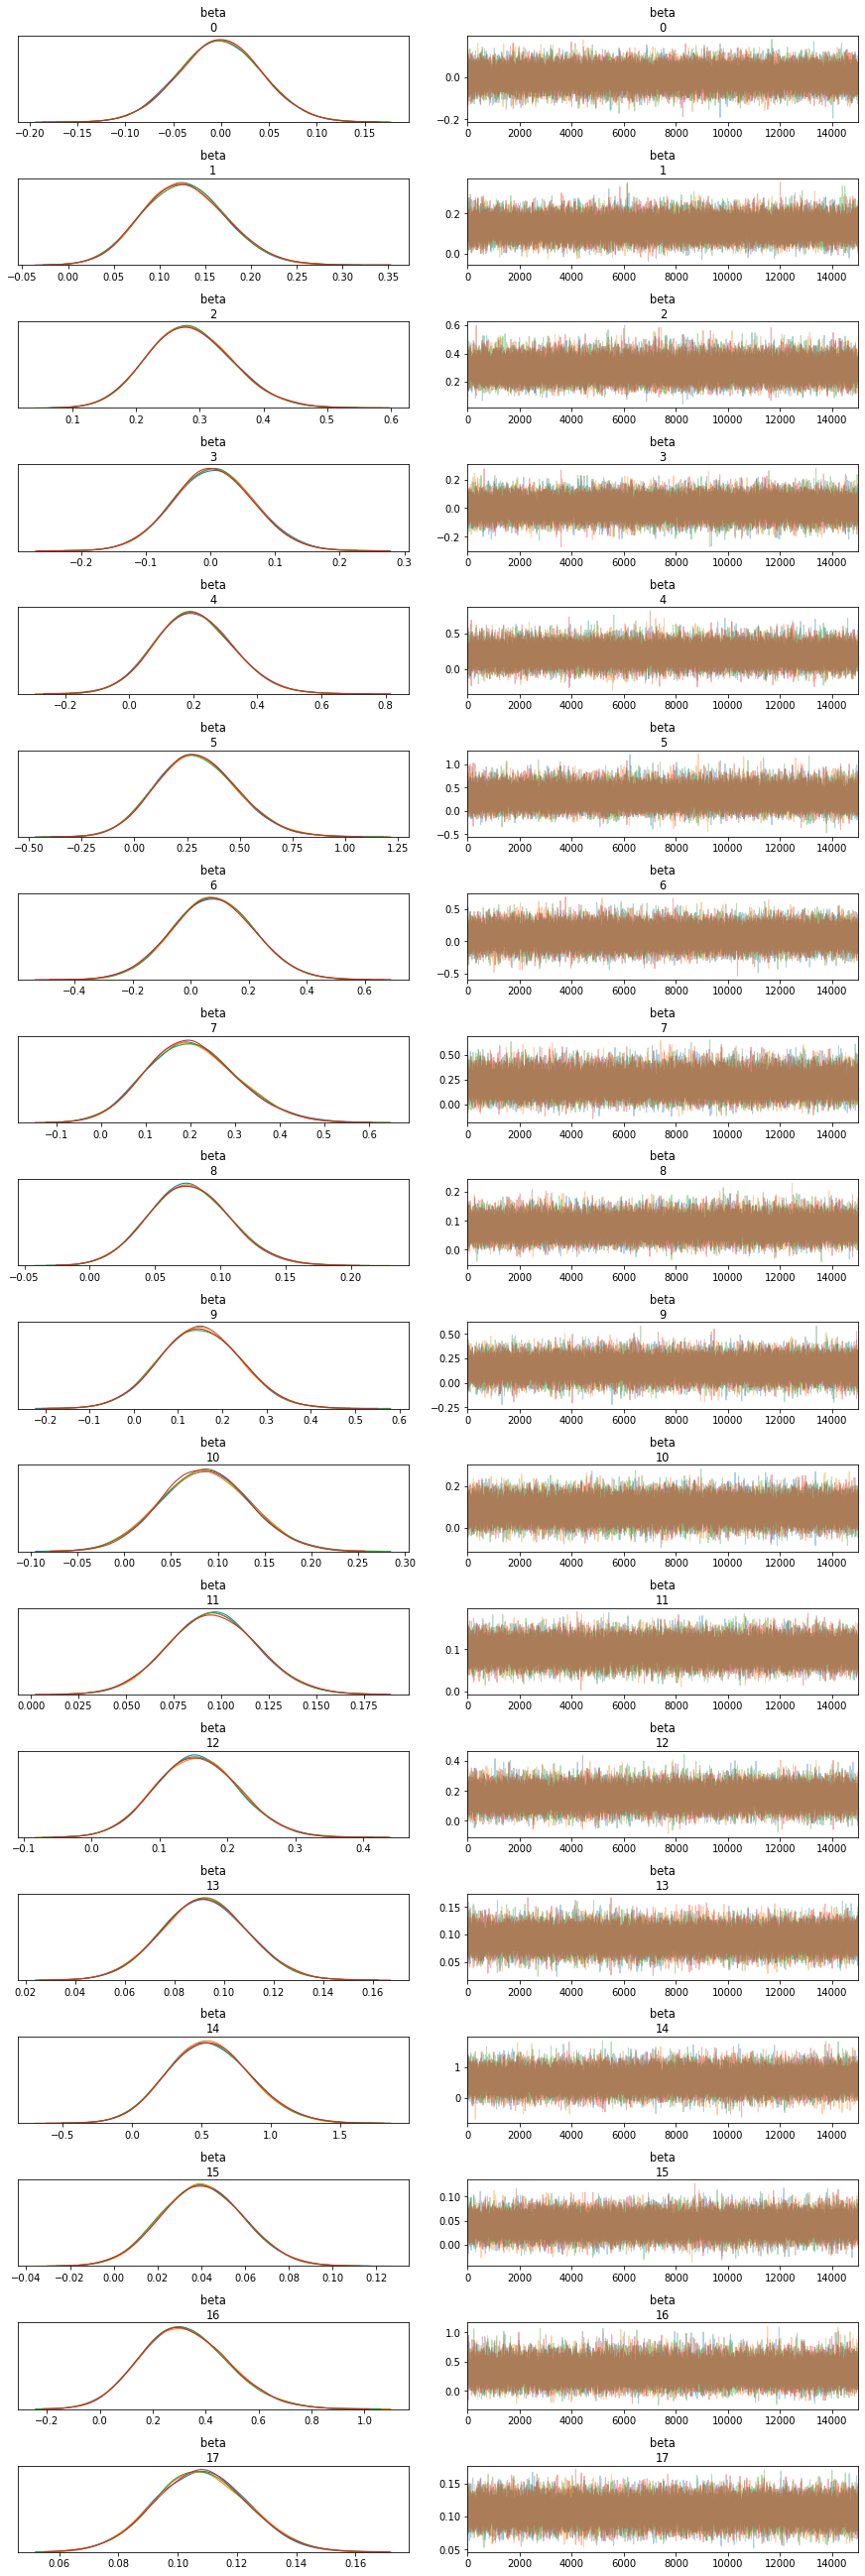

In [62]:
az.plot_trace(hcm_fit,var_names=('beta'))
plt.show()

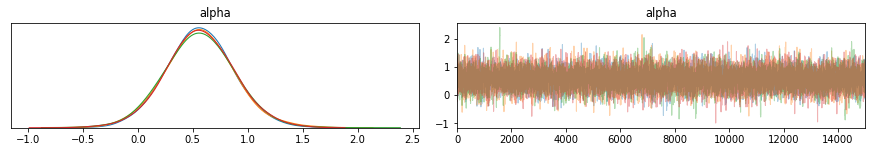

In [63]:
az.plot_trace(hcm_fit,var_names=('alpha'))
plt.show()

**Observation:** All the traceplots look good!

**Note:** Trace plots were shown only for alpha and beta to save space.

### 6.3. Parameter Inference

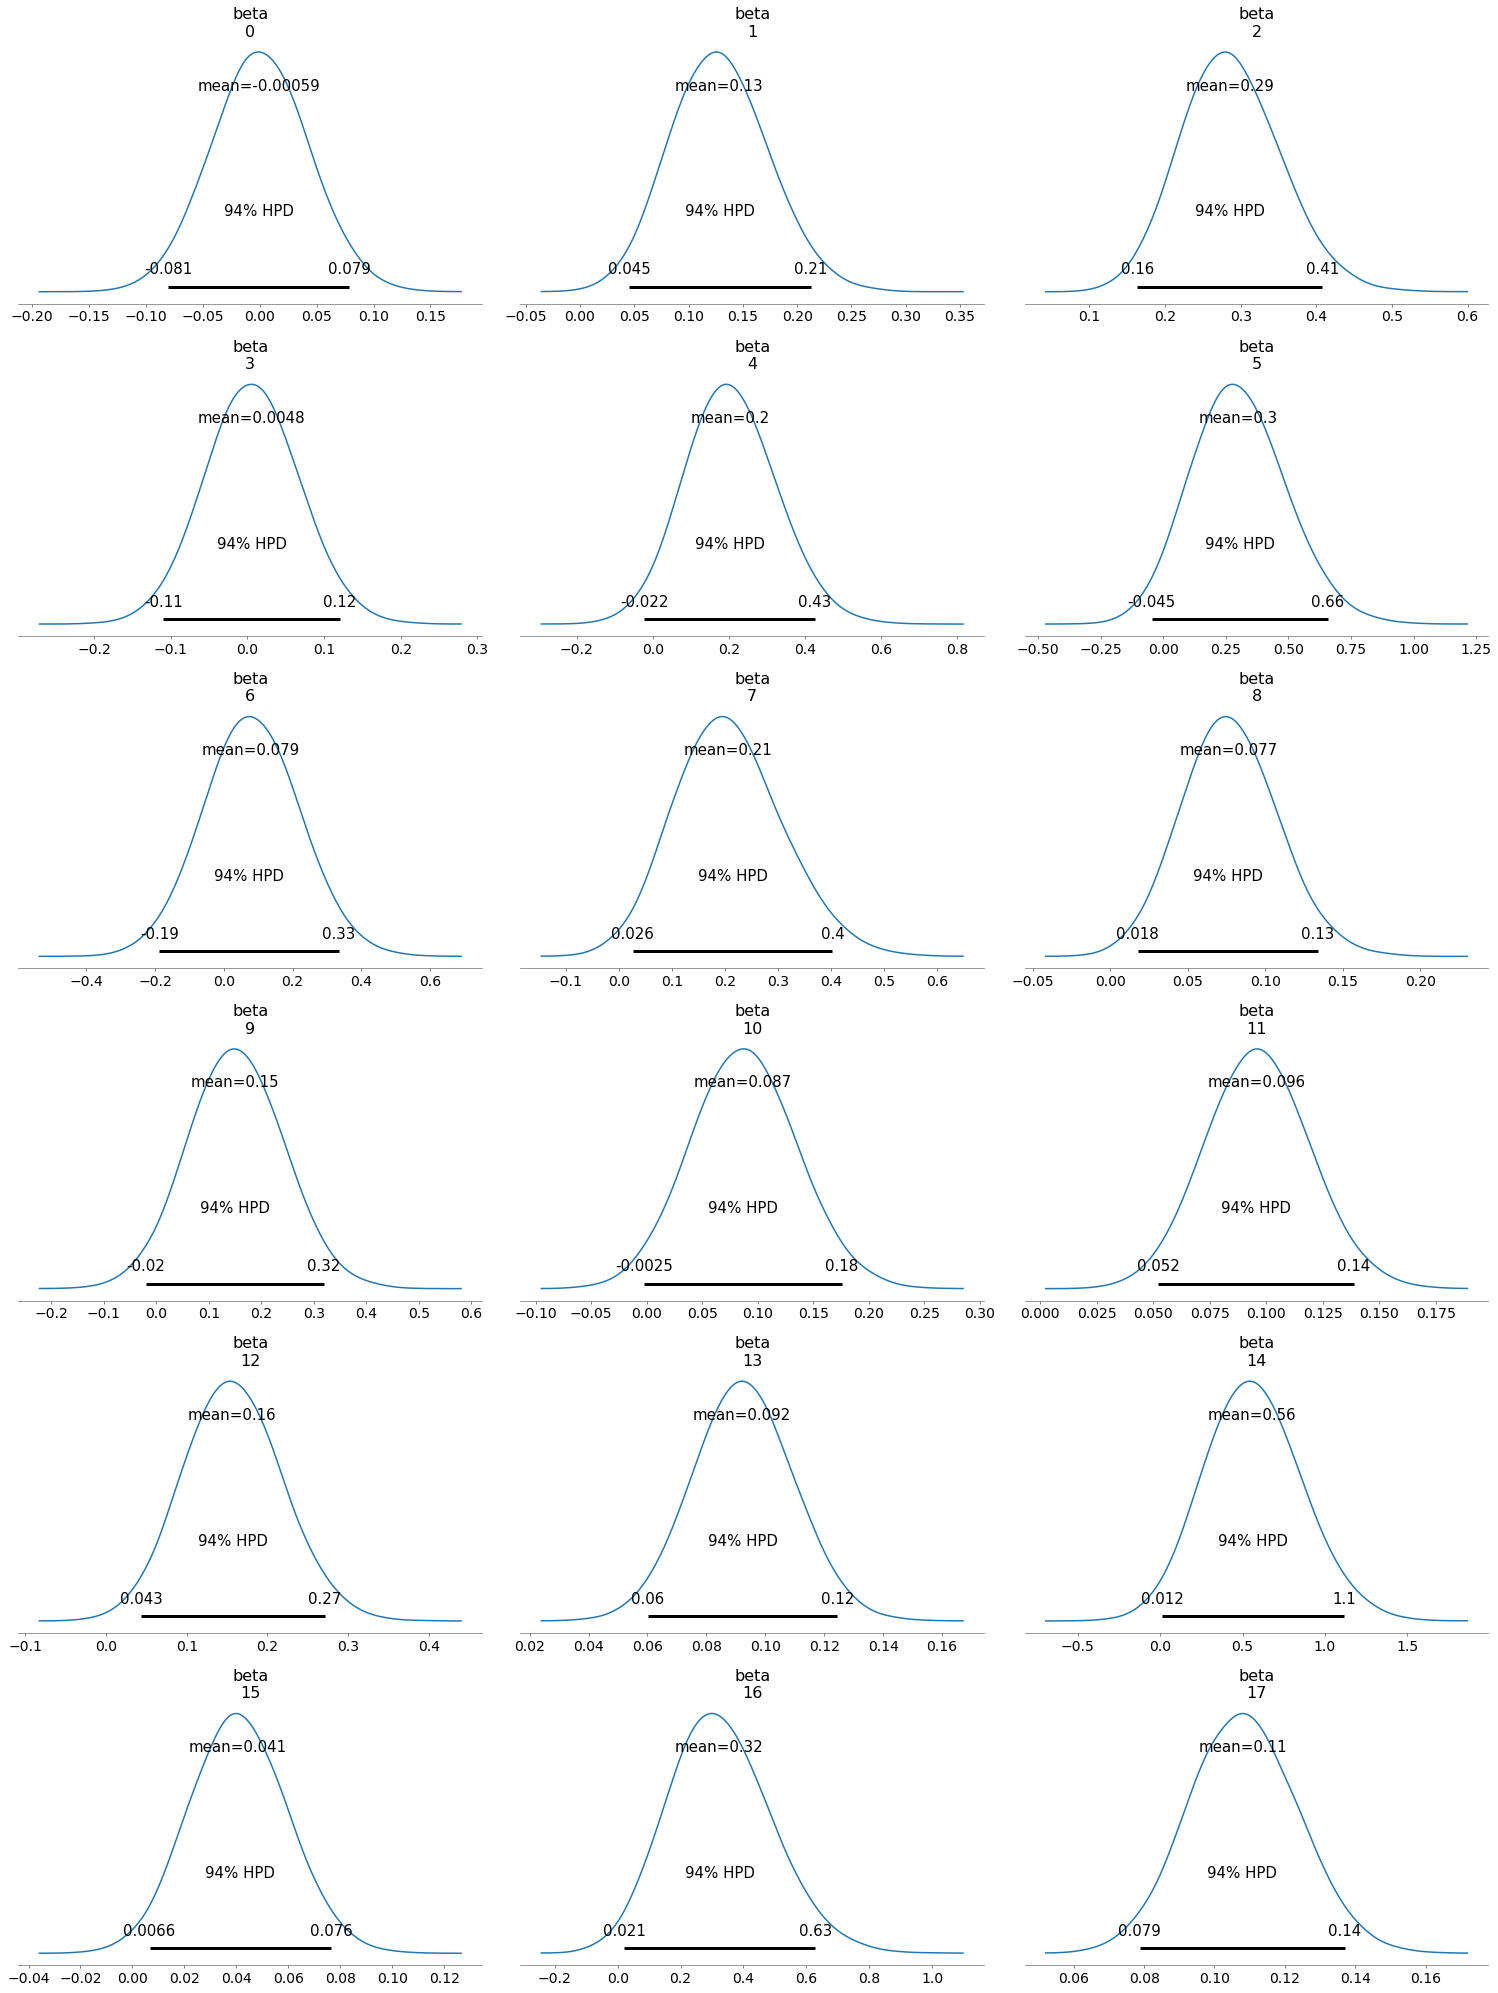

In [64]:
az.plot_posterior(hcm_fit,var_names='beta')
plt.show()

**Observation:** Confidence region of betas indicates the true range of increase/decrease of log-odds of success with OppKC. This gives us an idea about the spread of learning rates in the classroom. This is more useful than having a confidence interval for "true beta".

### 6.4. Understanding learning for each KC

In [66]:
predicted_hcm = np.mean(hcm_fit.extract('y_pred')['y_pred'],axis=0)

In [67]:
ds76_pred['p_success_hcm'] = predicted_hcm

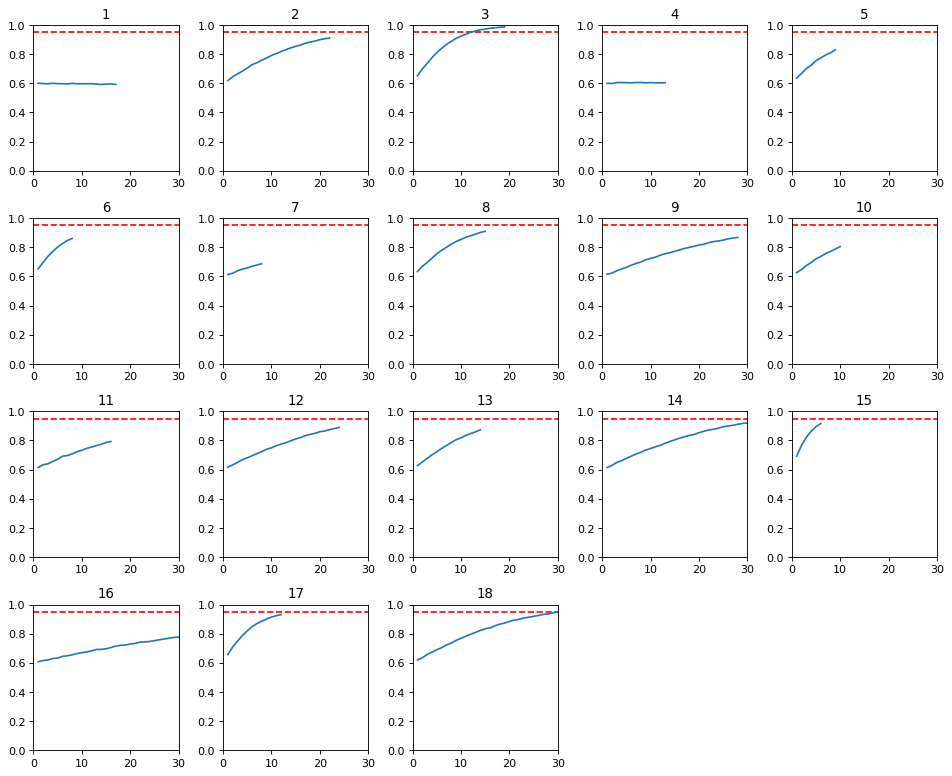

In [87]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

for c in range(1,ds76_pred.kc.max()+1):
    df0=ds76_pred[ds76_pred['kc']==c]
    ax = fig.add_subplot(5,5,c)
    ax.axhline(0.95, color='red', linestyle='--')
    ax.plot(df0['OppKC'], df0['p_success_hcm'])
    ax.set_xlim([0,30])
    ax.set_ylim([0,1])
    ax.set_title(c)

plt.tight_layout()
plt.show()

**Observation:** The above plots are generated to generalize the learning model to unseen students. By averaging over the random effects, we are able to predict the probability of success with additional opportunities. We expect students to practice a concept till they achieve master (p(Success)=.95m,as indicated by the red line). The above graphs show us: 1) concepts where students aren't practicing enough (not enough content? need more time?), 2) students practicing after they've mastered a concept (wasted effort), and 3) concepts with no learning (need better content or instruction?). This analysis can be used to improve the course content. 

**Note:** This simulation is not an obvious result when we use a frequentist method. Most people approximate p(Success) as E(logisitic(fixed effects)) while generalizing to unseen students. Even though random effects are normally distributed with mean 0, we cannot ignore the random effects while calculating the expected value of p(Success). This is because E(logistic(fixed effects)) ≠ E(logistic(fixed effects + normal(0, sigma)). Bayesian method allows us to calculate E(p(Success)) while averaging over the random effects. 

## 7. A Strong Case for the Bayesian Method

One can argue that E(p(Success)) can be calculated using frequentist methods such as Generalized Linear Mixed Models by averaging the p(Success) over the entire grid of all the Students and Questions. Even though this might seem like a reasonable approach for the current dataset, calculating the average over the entire grid of random variables becomes very expensive when we move to a larger dataset such as [OLI C@CM v2.1 - Fall 2010](https://pslcdatashop.web.cmu.edu/DatasetInfo?datasetId=2033) that has 765 students and 840 questions. That means computing E(p(Success)) for an OppKC and KC combination would require averaging 642,600 predictions. Now imagine doing that for a Massive Open Online Course! The beauty of the Bayesian (or MCMC) method lies in the ability to approximately calculate this E(p(Success)) with a much smaller random sample.

## 8. Conclusion

The Strong Component Model (SCM) ignores the difference in difficulty levels of the questions (items) in KCs to avoid issues with sparsity of data at the item-level. The Weak Component Model (WCM) addresses this item-level sparsity issue by introducing "Item" as a random effect. However, the WCM ignores correlation of observations at KC-level. Because of the limitations of the assumptions in SCM and WCM we observe negative learning curves in section 4.4 and 5.4. Negative learning curves can be spotted for KCs "Geometry\*ALT:TRIANGLE-AREA"(4) & "Geometry\*Subtract\*Textbook_New_Decompose-compose-by-addition" (7) in SCM, and for "Geometry\*equi-tri-height?" (15) in WCM. The Hierarchical Model overcomes this issue by correctly specifying the structure of correlations in the data. 

Koedinger et al. in "Using a Hierarchical Model to Get the Best of Both Worlds: Good Prediction and Good Explanation" (2018) have already demonstrated the superiority of HCM compared to SCM and WCM. However, DataShop is yet to adopt the Hierarchical Model (HM) in lieu of SCM for generating the learning curves. Besides the obvious issue of negative learning rate from SCM and WCM pointed out above, there are also noticeable differences in the learning curves from SCM and HM. For example, SCM indicates low learning rate for "Geometry\*parallelogram-area" (16) and "Geometry\*parallelogram-area\*Textbook_New_Decompose-compose-by-addition" (17). This doesn't seem to be case when we look at HM learning curves for these KCs.

## 9. Further Steps

These results need to replicated on other datasets before there is conclusive evidence that the learning curves from Hierarchical Model are both reliable and more meaningful. Bayes Factor can be used to compare SCM, WCM, and HM. (Note: I tried using 'bridgesampling' package in R to compute Bayes Factor by the results were strange — Bayes Factor in the order of billions )